### 1. Import dependencies

In [1]:
import os
import copy
import numpy as np
from PIL import Image

In [2]:
import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

from keras import Model, layers

from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# from keras import Sequential

Using TensorFlow backend.


In [3]:
keras.__version__

'2.2.2'

### 2. Create Keras data generators 

In [5]:
data_dir ='data_ready'
data_dir_train = os.path.join(data_dir, 'train')
data_dir_validation = os.path.join(data_dir, 'validation')

img_size = 224
batch_size = 32
epochs = 3

In [6]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    data_dir_train,
    batch_size=batch_size,
    class_mode='binary',
    target_size=(img_size,img_size))

validation_generator = validation_datagen.flow_from_directory(
    data_dir_validation,
    shuffle=False,
    class_mode='binary',
    target_size=(img_size,img_size))

Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### 3. Import pre-trained ResNet50 and stack trainable layers on top of it

In [7]:
# keras.backend.set_learning_phase(0) # see https://github.com/keras-team/keras/issues/9214  and https://github.com/keras-team/keras/pull/9965

conv_base = ResNet50(
    include_top=False,
    weights='imagenet')

# freeze layers in ResNet50
for layer in conv_base.layers:
    layer.trainable = False

/home/patryk/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 11s 0us/step


In [8]:
model = conv_base.output
# keras.backend.set_learning_phase(1)
model = layers.GlobalAveragePooling2D()(model)

# add fc layers to replace the one we removed.
model = layers.Dense(128, activation='relu')(model) 
predictions = layers.Dense(2, activation='softmax')(model)

In [9]:
model = Model(conv_base.input, predictions)

### 4. Prepare model checkpointing

In [10]:
model_checkpoint_dir = "./saved_models/keras"

if not os.path.exists(model_checkpoint_dir):
    os.makedirs(model_checkpoint_dir)
    print('Created directory: ', model_checkpoint_dir)

model_checkpoint_path = os.path.join(model_checkpoint_dir, "best_model.hdf5")

In [11]:
checkpoint_save_best = ModelCheckpoint(model_checkpoint_path,
                                       monitor='val_acc',
                                       verbose=1, 
                                       save_best_only=True, 
                                       save_weights_only=False, 
                                       mode='max', 
                                       period=1)

### 5. Compile and train the model

In [12]:
optimizer = keras.optimizers.rmsprop()

In [13]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit_generator(generator=train_generator,
                              epochs=epochs,
                              validation_data=validation_generator,
                              steps_per_epoch = train_generator.n // batch_size,
                              validation_steps = validation_generator.n // batch_size,
                              initial_epoch=0,
                              callbacks=[checkpoint_save_best])

Epoch 1/3
21/21 [==============================] - 292s 14s/step - loss: 0.8250 - acc: 0.7545 - val_loss: 0.3507 - val_acc: 0.8250

Epoch 00001: val_acc improved from -inf to 0.82500, saving model to ./saved_models/keras/best_model.hdf5
Epoch 2/3
21/21 [==============================] - 289s 14s/step - loss: 0.2633 - acc: 0.8895 - val_loss: 0.5002 - val_acc: 0.8050

Epoch 00002: val_acc did not improve from 0.82500
Epoch 3/3
21/21 [==============================] - 309s 15s/step - loss: 0.2706 - acc: 0.8951 - val_loss: 0.6891 - val_acc: 0.7800

Epoch 00003: val_acc did not improve from 0.82500


### 6. Load the best model checkpoint

In [15]:
keras.backend.clear_session()
loaded_model = load_model(model_checkpoint_path, compile=False)

### 7. Evaluate the model on a sample test image

In [60]:
valid_img = "data_ready/validation/predator/77.jpg"

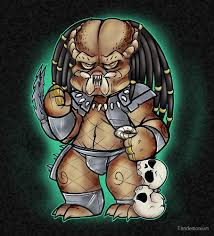

In [61]:
img = Image.open(valid_img)
img

In [62]:
img = img.resize((img_size, img_size))
img_array = np.array(img)
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

In [63]:
pred_probs = loaded_model.predict(img_array)[0]
pred_probs

array([0.02772434, 0.9722757 ], dtype=float32)

In [64]:
pred_prob = pred_probs[0]
if pred_prob > 0.5:
    print("IT'S AN ALIEN! ({:.2})".format(pred_prob))
else:
    print("IT'S A PREDATOR! ({:.2})".format(pred_prob))

IT'S A PREDATOR! (0.028)


below is a version for 3 pictures

In [87]:
test_image_path = ["/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/test/cats/cat.1505.jpg",
                   "/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/test/cats/cat.1506.jpg",
                   "/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/test/dogs/dog.1505.jpg"]

In [88]:
images = []

for path in test_image_path:
    images.append(Image.open(path))

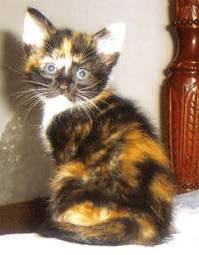

In [89]:
images[0]

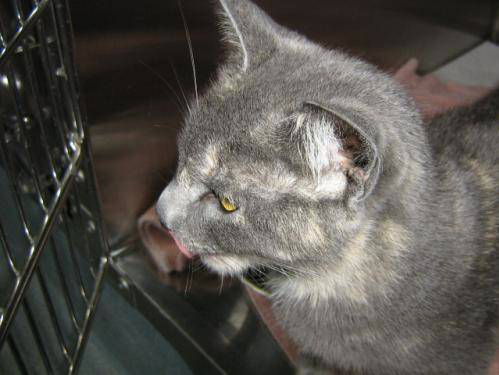

In [90]:
images[1]

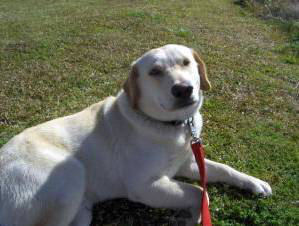

In [91]:
images[2]

In [92]:
img_array = np.zeros((len(images),img_size,img_size,3))

for i, image in enumerate(images):
    img_array[i,:,:,:] = preprocess_input(np.array(image.resize((img_size, img_size))))

In [93]:
pred_probs = loaded_model.predict(img_array)
pred_probs

array([[9.9902534e-01, 9.7469462e-04],
       [9.9975652e-01, 2.4350621e-04],
       [1.8423656e-03, 9.9815768e-01]], dtype=float32)

In [94]:
for i in range(pred_probs.shape[0]):
    pred_prob = pred_probs[i,0]
    if pred_prob > 0.5:
        print("IT'S A CAT! ({:.2})".format(pred_prob))
    else:
        print("IT'S A DOG! ({:.2})".format(pred_prob))

IT'S A CAT! (1.0)
IT'S A CAT! (1.0)
IT'S A DOG! (0.0018)
